# 2.6 Augmented Dickey-Fuller Test for Stationarity

In this notebook we will seek to encode our price columns in such a fashion that they have both memory and stationarity. If the data is not stationary, we will not be able to build a predictive because the basis for learning requires values to repeat in some predictable pattern. If the values are randomly walking around and the relative mean is constantly changing, then our model will have no reference point to make predictions. 

However, if we remove all memory the model will fail to learning a meaningful pattern. Whatever it does learn will likely not be of predictive value. What we want here is stationary data (previous values and future values have a constant mean) with memory (previous values correlate to future values). 

In order to do so, we will implement a fractional differnces algorithm and check the ADF-statistic over possible values in [0,1]. We will choose the minimum difference d such that stationarity is achieved. By doing so, we will preserve the maximum amount of memory possible. 

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone  
import time

In [2]:
df = pd.read_csv('../data/sp500/interval_data_100milvol.csv')
df.head()

,cum_value_interval,AAL_close,AAL_high,AAL_low,AAL_open,AAL_value_close,AAL_volume,AAPL_close,AAPL_high,AAPL_low,...,ZION_low,ZION_open,ZION_value_close,ZION_volume,ZTS_close,ZTS_high,ZTS_low,ZTS_open,ZTS_value_close,ZTS_volume
0,"(0.0, 100000000.0]",13.29,13.46,13.2700,13.3000,9.861808e+05,73989.0,115.5250,115.6625,115.4500,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0
1,"(100000000.0, 200000000.0]",13.31,13.34,13.2400,13.2900,1.080460e+06,81287.0,115.5975,115.6000,115.1925,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0
2,"(200000000.0, 300000000.0]",13.29,13.35,13.2800,13.3199,1.024083e+06,76922.0,115.7250,115.8250,115.5975,...,NaN,NaN,0.0,0.0,158.75,158.75,158.75,158.75,15875.0,100.0
3,"(300000000.0, 400000000.0]",13.34,13.34,13.2898,13.2900,1.135384e+06,85273.0,115.9275,116.0000,115.7250,...,NaN,NaN,0.0,0.0,158.75,158.75,158.75,158.75,0.0,0.0
4,"(400000000.0, 500000000.0]",13.40,13.40,13.3499,13.3499,4.020905e+05,30018.0,115.9275,115.9425,115.9075,...,NaN,NaN,0.0,0.0,157.05,157.05,157.05,157.05,6187770.0,39400.0


In [3]:
df.dropna(inplace=True)

In [4]:
df.shape

(33042, 3031)

In [29]:
adf = adfuller(df['AAL_close'], maxlag=1, regression='c', autolag=None)
adf

(-3.2939649280828927,
 0.015150407099260273,
 1,
 33040,
 {'1%': -3.430547936081223,
  '5%': -2.861627482693232,
  '10%': -2.56681656431653})

In [30]:
adf[0]

-3.2939649280828927

In [31]:
list(adf[:4]) + [adf[4]['5%']]

[-3.2939649280828927, 0.015150407099260273, 1, 33040, -2.861627482693232]

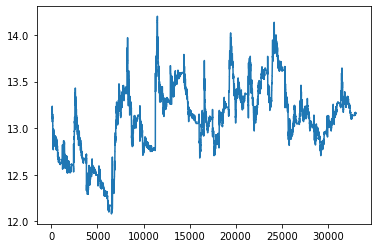

In [32]:
plt.plot(df['AAL_close'])

Surprisingly, we see that 'AAL_close' is already stationary. Therefore, it does not require *any* differencing. 

Let's write an algorithm to check the undifferenced ADF and see which, if any, columns require differncing. 

In [5]:
def fuller_test(series, maxlag=1, regression='c',autolag=None):
    adf = adfuller(series.dropna(), maxlag=1, regression='c', autolag=None)
    return pd.Series(list(adf[:4]) + [adf[4]['5%']] + [1] + [0], index = ['adfStat',
                                                                          'pVal',
                                                                          'lags',
                                                                          'nObs',
                                                                          '95% conf',
                                                                          'corr',
                                                                          'fracD'])


In [ ]:
adf_test = df[df.columns.drop('cum_value_interval')].apply(fuller_test)

adf_test

In [65]:
adf_test[adf_test.columns[adf_test.loc['pVal'] > 0.05]]

,AAPL_close,AAPL_high,AAPL_low,AAPL_open,ABBV_close,ABBV_high,ABBV_low,ABBV_open,ABC_close,ABC_high,...,YUM_low,YUM_open,ZBRA_close,ZBRA_high,ZBRA_low,ZBRA_open,ZTS_close,ZTS_high,ZTS_low,ZTS_open
adfStat,-1.594879,-1.562697,-1.480212,-1.592159,-1.686896,-1.620541,-1.519671,-1.592567,-2.479268,-2.549520,...,-2.651748,-2.602070,-1.145607,-1.159616,-1.163775,-1.160694,-2.206560,-2.115101,-2.025727,-2.134992
pVal,0.486165,0.502300,0.543277,0.487531,0.437877,0.472446,0.523759,0.487326,0.120601,0.103886,...,0.082767,0.092570,0.696546,0.690722,0.688982,0.690272,0.203873,0.238486,0.275408,0.230679
lags,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
nObs,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000,...,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000,33040.000000
95% conf,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627,...,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627,-2.861627
corr,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
fracD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [352]:
adf_test[adf_test.columns[adf_test.loc['pVal'] > 0.05]].columns.str.contains('value').any()

False

In [353]:
adf_test[adf_test.columns[adf_test.loc['pVal'] > 0.05]].columns.str.contains('volume').any()

False

In [354]:
adf_test[adf_test.columns[adf_test.loc['pVal'] > 0.05]].columns.str.contains('open').any()

True

In [355]:
adf_test[adf_test.columns[adf_test.loc['pVal'] > 0.05]].columns.str.contains('close').any()

True

In [356]:
adf_test[adf_test.columns[adf_test.loc['pVal'] > 0.05]].columns.str.contains('high').any()

True

In [357]:
adf_test[adf_test.columns[adf_test.loc['pVal'] > 0.05]].columns.str.contains('low').any()

True

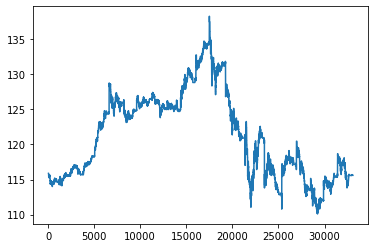

In [47]:
plt.plot(df['AAPL_close'])

With our first ADFuller test, we show that about 1,000 columns in our original dataset are not stationary. Those that are not stationary include all of the volume and value columns, leaving us only with price columns as nonstationary features. 

Those price columns which are stationary do not need to be differenced. For the rest (those that are not stationary), which should find the optimal differencing level to apply such that the series passes the ADFuller test with a pvalue < 0.05. 

In [6]:
def getWeights_FFD(d, thres):
    w, k=[1.],1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_) < thres: break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)


def fracDiff_FFD(series, d, thres=1e-5):
    '''
    Updated to take advantage of rolling window functions. 
    
    Single iteration runtime locally 3.55 s
    '''
    w = getWeights_FFD(d, thres)
    width = len(w)
    
    def dot_product(window):
        return np.dot(w.T, window)
    
    return series.rolling(width).apply(dot_product)


Original codebase copied from "AFML" (de Prado). 

Runtime for a single iteration: 31.7 seconds. 

```
def getWeights_FFD(d, thres):
    w, k=[1.],1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_) < thres: break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff_FFD(series, d, thres=1e-5):
    w, dffd = getWeights_FFD(d, thres), {}
    width = len(w)-1

    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]): continue
            
            df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
        dffd[name] = df_.copy(deep=True)
    
    dffd = pd.concat(dffd, axis=1)
    return dffd
```
    
The following operation was performed to time the runtime of the algorithm:

```
%%time
aapl_frac = fracDiff_FFD(df[['ZBRA_close']], d=0.15)
```

And produced the output: 

```
CPU times: user 31.7 s, sys: 17.8 ms, total: 31.7 s
Wall time: 31.7 s
```

After implementing our optimization, output of the same cell is produced below. 

In [262]:
%%time
rolling_func_res = fracDiff_FFD(df[['ZBRA_close']], d=0.15)

CPU times: user 3.53 s, sys: 61.2 ms, total: 3.59 s
Wall time: 3.55 s


In [232]:
np.corrcoef(df.loc[aapl_frac.index, 'ZBRA_close'], aapl_frac['ZBRA_close'])[0,1]

0.9825088866208556

In [318]:
col = 'ZBRA_close'
np.corrcoef(df.loc[rolling_func_res[col].dropna().index, col], rolling_func_res[col].dropna())[0,1]

0.9825088866208556

In [233]:
adfuller(aapl_frac['ZBRA_close'], maxlag=1, regression='c', autolag=None)

(-3.2757686921318347,
 0.015996975338855367,
 1,
 29140,
 {'1%': -3.430574429517509,
  '5%': -2.8616391916728112,
  '10%': -2.566822796719173})

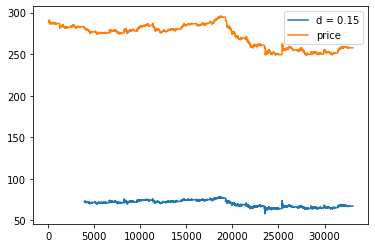

In [235]:
plt.plot(aapl_frac['ZBRA_close'], label='d = 0.15')
plt.plot(df['ZBRA_close'], label='price')
plt.legend()

In [351]:
df2 = df.copy(deep=True)
adf_test.shape

(7, 3030)

Prior to optimizing, we identified that our desired algorithm for searching for the best d-value for each stock would have taken somewhere on the order of 1-10 days. 

With 1590 stocks, a runtime of 31 seconds each, and an iterative approach to finding the best d-value, one iteration would take roughly 11 hours to complete. Up to 20 iterations max for a worst case runtime of (31 seconds * 1590 stocks * 20 iterations = 985,800 seconds / 3600 minutes / 24 hours = 11.4 days). 

This was not reasonable, so we optimized the function using pandas rolling apply, and cut the magnitude down by one order. Now, one iteration through all the non-stationary stocks should take about 1.5 hours, with a worst case runtime of 30 hours. 

Since we expect the majority of stocks to be solved within the first few iterations, this is now acceptable. 

In [ ]:
start = time.time()

remaining_cols = adf_test[adf_test.columns[adf_test.loc['pVal'] > 0.05]].columns
d_value = 0.05

while remaining_cols.shape[0] > 0 and d_value <= 1:
    # impute the fracDiff for the current d on the remaining cols 
    print('Beginning fracDiff ---')
    print(f'Current d value: {d_value}')
    print(f'Time Elapsed: {time.time() - start}')
    print(f'Remaining Columns: {remaining_cols.shape[0]}')
    print(f'Expected Runtime {remaining_cols.shape[0] * 3.55/3600}')
    print('Current Time: {}'.format(datetime.now(timezone("US/Pacific")).strftime('%-I:%M:%S')))
    print('/n')
    
    df2[remaining_cols] = fracDiff_FFD(df[remaining_cols], d=d_value)
    # with the new diffed
    adf_test[remaining_cols] = df2[remaining_cols].apply(fuller_test)
    for col in remaining_cols:
        adf_test.loc['corr', col] = np.corrcoef(df.loc[df2[col].dropna().index, col], df2[col].dropna())[0,1]
        adf_test.loc['fracD', col] = d_value
    
    remaining_cols = adf_test[adf_test.columns[adf_test.loc['pVal'] > 0.05]].columns
    print(f'COMPLETE: fracDiff d:{d_value}')
    print(f'current remaining cols:{remaining_cols.shape[0]}')
    print('\n')
    
    adf_test.to_csv('../data/adf_testing/adf_testing_d{}.csv'.format(int(d_value*100)))
    df2.to_csv('../data/adf_testing/fracdiff_d{}.csv'.format(int(d_value*100)))
    d_value+=0.05

Beginning fracDiff
Current d value 0.05
Time elapsed: 0.005811452865600586
Remaining_cols shape[0]: 1592
Expected runtime 1.5698888888888887
Current time: 4:14:42

fracdiff d:0.25 complete, current remaining cols:1016
Beginning fracDiff
Current d value 0.1
Time elapsed: 5918.516360759735
Remaining_cols shape[0]: 1016
Expected runtime 1.0018888888888888
Current time: 5:53:20



Unforunately, due to a kernal overload part way through the loop had to be restarted. For posterity, the output of the cells has been recorded and compiled in markdown below. 

```
Beginning fracDiff
Current d value 0.05
Time elapsed: 0.005811452865600586
Remaining_cols shape[0]: 1592
Expected runtime 1.5698888888888887
Current time: 4:14:42
COMPLETE: fracdiff d:0.05 
current remaining cols:1016

Beginning fracDiff ---
Current d value: 0.1
Time elapsed: 5918.516360759735
Remaining Columns: 1016
Expected Runtime 1.0018888888888888
Current Time: 6:23:55
COMPLETE: fracDiff d:0.1
current remaining cols:338

Beginning fracDiff ---
Current d value: 0.15000000000000002
Time Elapsed: 3895.2930240631104
Remaining Columns: 338
Expected Runtime 0.3333055555555555
Current Time: 7:28:51
COMPLETE: fracDiff d:0.15000000000000002
current remaining cols:30

Beginning fracDiff ---
Current d value: 0.2
Time Elapsed: 5242.763531923294
Remaining Columns: 30
Expected Runtime 0.029583333333333333
Current Time: 7:51:18
COMPLETE: fracDiff d:0.2
current remaining cols:0
```

Interestingly, all the series were made stationary with a maximum d of 0.2, much lower than the guidelines in "AFML". 